In [1]:
import os
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import pandas as pd
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

In [2]:
os.getcwd()

os.chdir('../')

os.getcwd()

'/Users/srikaranreddy/Desktop/Spring Semester/Computer Vision 6.8300/cv-project/gi-tract-image-segmentation'

In [3]:
from src.data import SegmentationDataset
from src.data import DataGenerator, DataLoader
from src.model import SimpleUNet
from src.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src.utils.plot_utils import plot_masks, display_comparison

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [4]:
viz_generator_class = DataGenerator(dataset_dir='datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='datasets/coco/viz_json.json',
                                     shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
from src.utils.plot_utils import plot_masks

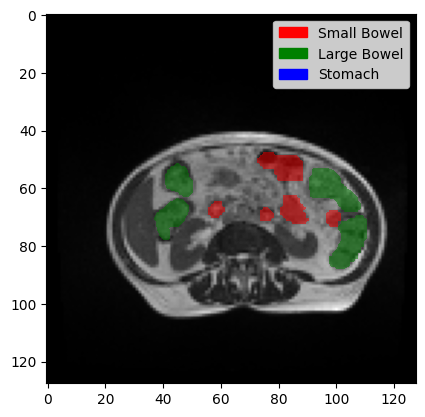

In [13]:
from matplotlib.colors import ListedColormap

X, y = viz_generator_class.__getitem__(3)

plot_masks(X, y)

In [14]:
viz_loader = DataLoader(viz_generator_class, batch_size=32, num_workers=0)
viz_loader

In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [16]:
model = SimpleUNet()
input = torch.randn(1, 3, 128, 128)  # Example input
output = model(input)
print(output.shape)  # Should be torch.Size([1, 3, 128, 128])

torch.Size([1, 3, 128, 128])


### Simple UNET

In [39]:
from src.model import SimpleUNet
from src.loss import DiceLoss
criterion = DiceLoss().to(device)
# dice_loss = DiceLoss(to_onehot_y=False, softmax=True)

iou_criterion = IoU().to(device)

In [40]:
!ls models

DeepLab_model_epoch_3.pth           UNet_EfficientNet_model_epoch_6.pth
SimpleUNet_model_epoch_7.pth        small_UNET_model_epoch_8.pth


In [41]:
model = SimpleUNet().to(device)

# Load the saved model weights
model.load_state_dict(torch.load('models/small_UNET_model_epoch_8.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode if you are making predictions
model.eval()

SimpleUNet(
  (inc): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu1): LeakyReLU(negative_slope=0.1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu2): LeakyReLU(negative_slope=0.1)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu1): LeakyReLU(negative_slope=0.1)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): InstanceNorm2d(128, eps=1e-05, m

In [42]:
from tqdm import tqdm 

images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data, target in tqdm(viz_loader):
        # Assuming your DataLoader returns a tuple of (images, labels)

        images = data.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # print(images.shape)
        # Generate predictions
        output = model(images)
        predictions.append(output)
        # print(output.shape)

        mask = target.permute(0, 3, 1, 2).to(device)
        masks.append(mask)
        # print(mask.shape)

        dice_loss = criterion(output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(output, mask)

        test_dice_loss_meter.update(dice_loss.item(), output.size(0))
        test_iou_meter_0.update(iou_value0.item(), output.size(0))
        test_iou_meter_1.update(iou_value1.item(), output.size(0))
        test_iou_meter_2.update(iou_value2.item(), output.size(0))


print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]

Test Dice Loss: 0.2299, 
         IOU for SB:  0.1760, 
         IOU for LB:  0.5231, 
         IOU for S:  0.3169


In [44]:
img_s = images_test[0]
pred_sunet = predictions[0]
actual_masks = masks[0]

In [45]:
# img_s = images_test[0]
# pred_sunet = predictions[0]
# actual_masks = masks[0]

# display_comparison(img_s.cpu().numpy(), pred_sunet.cpu().numpy(), actual_masks.cpu().numpy())

### DeepLabV3+

In [46]:
import segmentation_models_pytorch as smp

In [47]:
model = smp.DeepLabV3Plus(
    encoder_name="resnext101_32x8d",   # Example of using a powerful ResNeXt model
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

# Load the saved model weights
model.load_state_dict(torch.load('models/DeepLab_model_epoch_3.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode if you are making predictions
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [48]:
from tqdm import tqdm 

images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data, target in tqdm(viz_loader):
        # Assuming your DataLoader returns a tuple of (images, labels)

        images = data.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # print(images.shape)
        # Generate predictions
        output = model(images)
        predictions.append(output)
        # print(output.shape)

        mask = target.permute(0, 3, 1, 2).to(device)
        masks.append(mask)
        # print(mask.shape)

        dice_loss = criterion(output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(output, mask)

        test_dice_loss_meter.update(dice_loss.item(), output.size(0))
        test_iou_meter_0.update(iou_value0.item(), output.size(0))
        test_iou_meter_1.update(iou_value1.item(), output.size(0))
        test_iou_meter_2.update(iou_value2.item(), output.size(0))


print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]

Test Dice Loss: -0.1169, 
         IOU for SB:  0.2380, 
         IOU for LB:  0.7649, 
         IOU for S:  0.5729


In [49]:
img_s = images_test[0]
pred_dlv3 = predictions[0]
actual_masks = masks[0]

# display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())

### Efficient Net - UNet

In [50]:
!ls models

DeepLab_model_epoch_3.pth           UNet_EfficientNet_model_epoch_6.pth
SimpleUNet_model_epoch_7.pth        small_UNET_model_epoch_8.pth


In [51]:
model = smp.Unet(
    encoder_name="efficientnet-b6",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

# Load the saved model weights
model.load_state_dict(torch.load('models/UNet_EfficientNet_model_epoch_6.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode if you are making predictions
model.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 56, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          56, 56, kernel_size=(3, 3), stride=[1, 1], groups=56, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(56, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          56, 14, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          14, 56, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [52]:
from tqdm import tqdm 

images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data, target in tqdm(viz_loader):
        # Assuming your DataLoader returns a tuple of (images, labels)

        images = data.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # print(images.shape)
        # Generate predictions
        output = model(images)
        predictions.append(output)
        # print(output.shape)

        mask = target.permute(0, 3, 1, 2).to(device)
        masks.append(mask)
        # print(mask.shape)

        dice_loss = criterion(output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(output, mask)

        test_dice_loss_meter.update(dice_loss.item(), output.size(0))
        test_iou_meter_0.update(iou_value0.item(), output.size(0))
        test_iou_meter_1.update(iou_value1.item(), output.size(0))
        test_iou_meter_2.update(iou_value2.item(), output.size(0))


print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]

Test Dice Loss: -0.1393, 
         IOU for SB:  0.0000, 
         IOU for LB:  0.8095, 
         IOU for S:  0.6143


In [54]:
img_s = images_test[0]
pred_en = predictions[0]
mask_s = masks[0]

# display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def display_comparison(img_s, actual_mask, pred_sunet, pred_dlv3, pred_en):
    num_images = len(img_s)
    fig, axes = plt.subplots(num_images, 4, figsize=(15, 5 * num_images))

    for i in range(num_images):
        plt.subplot(num_images, 4, 4*i + 1)
        X, y = img_s[i], actual_mask[i]
        if X.shape[0] == 3:  # Assuming 3 channels
            X = np.transpose(X, (1, 2, 0))  # Convert X from (3, 128, 128) to (128, 128, 3)
        
        # Similarly adjust y if it is in the shape (3, 128, 128)
        if y.shape[0] == 3:
            y = np.transpose(y, (1, 2, 0)) 

        cmap1 = ListedColormap(['none', 'red'])  # Mask 1 in red
        cmap2 = ListedColormap(['none', 'green'])  # Mask 2 in green
        cmap3 = ListedColormap(['none', 'blue'])  # Mask 3 in blue
    
        # Display the grayscale image
        plt.imshow((X/255.)[:,:,0], cmap='gray')
    
        # Display the masks
        plt.imshow(y[:, :, 0], cmap=cmap1, alpha=0.5)  # Display the first mask
        plt.imshow(y[:, :, 1], cmap=cmap2, alpha=0.5)  # Display the second mask
        plt.imshow(y[:, :, 2], cmap=cmap3, alpha=0.5)  # Display the third mask
    
        plt.title(f"Actual Mask")

        plt.subplot(num_images, 4, 4*i + 2)
        X, y = img_s[i], pred_sunet[i]
        if X.shape[0] == 3:  # Assuming 3 channels
            X = np.transpose(X, (1, 2, 0))  # Convert X from (3, 128, 128) to (128, 128, 3)
        
        # Similarly adjust y if it is in the shape (3, 128, 128)
        if y.shape[0] == 3:
            y = np.transpose(y, (1, 2, 0)) 
    
        # Display the grayscale image
        plt.imshow((X/255.)[:,:,0], cmap='gray')
    
        # Display the masks
        plt.imshow(y[:, :, 0], cmap=cmap1, alpha=0.5)  # Display the first mask
        plt.imshow(y[:, :, 1], cmap=cmap2, alpha=0.5)  # Display the second mask
        plt.imshow(y[:, :, 2], cmap=cmap3, alpha=0.5)  # Display the third mask
    
        plt.title(f"Simple U-Net")

        plt.subplot(num_images, 4, 4*i + 3)
        X, y = img_s[i], pred_dlv3[i]
        if X.shape[0] == 3:  # Assuming 3 channels
            X = np.transpose(X, (1, 2, 0))  # Convert X from (3, 128, 128) to (128, 128, 3)
        
        # Similarly adjust y if it is in the shape (3, 128, 128)
        if y.shape[0] == 3:
            y = np.transpose(y, (1, 2, 0)) 
    
        # Display the grayscale image
        plt.imshow((X/255.)[:,:,0], cmap='gray')
    
        # Display the masks
        plt.imshow(y[:, :, 0], cmap=cmap1, alpha=0.5)  # Display the first mask
        plt.imshow(y[:, :, 1], cmap=cmap2, alpha=0.5)  # Display the second mask
        plt.imshow(y[:, :, 2], cmap=cmap3, alpha=0.5)  # Display the third mask
    
        plt.title(f"DeepLabV3+")

        plt.subplot(num_images, 4, 4*i + 4)
        X, y = img_s[i], pred_en[i]
        if X.shape[0] == 3:  # Assuming 3 channels
            X = np.transpose(X, (1, 2, 0))  # Convert X from (3, 128, 128) to (128, 128, 3)
        
        # Similarly adjust y if it is in the shape (3, 128, 128)
        if y.shape[0] == 3:
            y = np.transpose(y, (1, 2, 0)) 
    
        # Display the grayscale image
        plt.imshow((X/255.)[:,:,0], cmap='gray')
    
        # Display the masks
        plt.imshow(y[:, :, 0], cmap=cmap1, alpha=0.5)  # Display the first mask
        plt.imshow(y[:, :, 1], cmap=cmap2, alpha=0.5)  # Display the second mask
        plt.imshow(y[:, :, 2], cmap=cmap3, alpha=0.5)  # Display the third mask
    
        plt.title(f"Efficient Net")

    plt.tight_layout()
    plt.show()


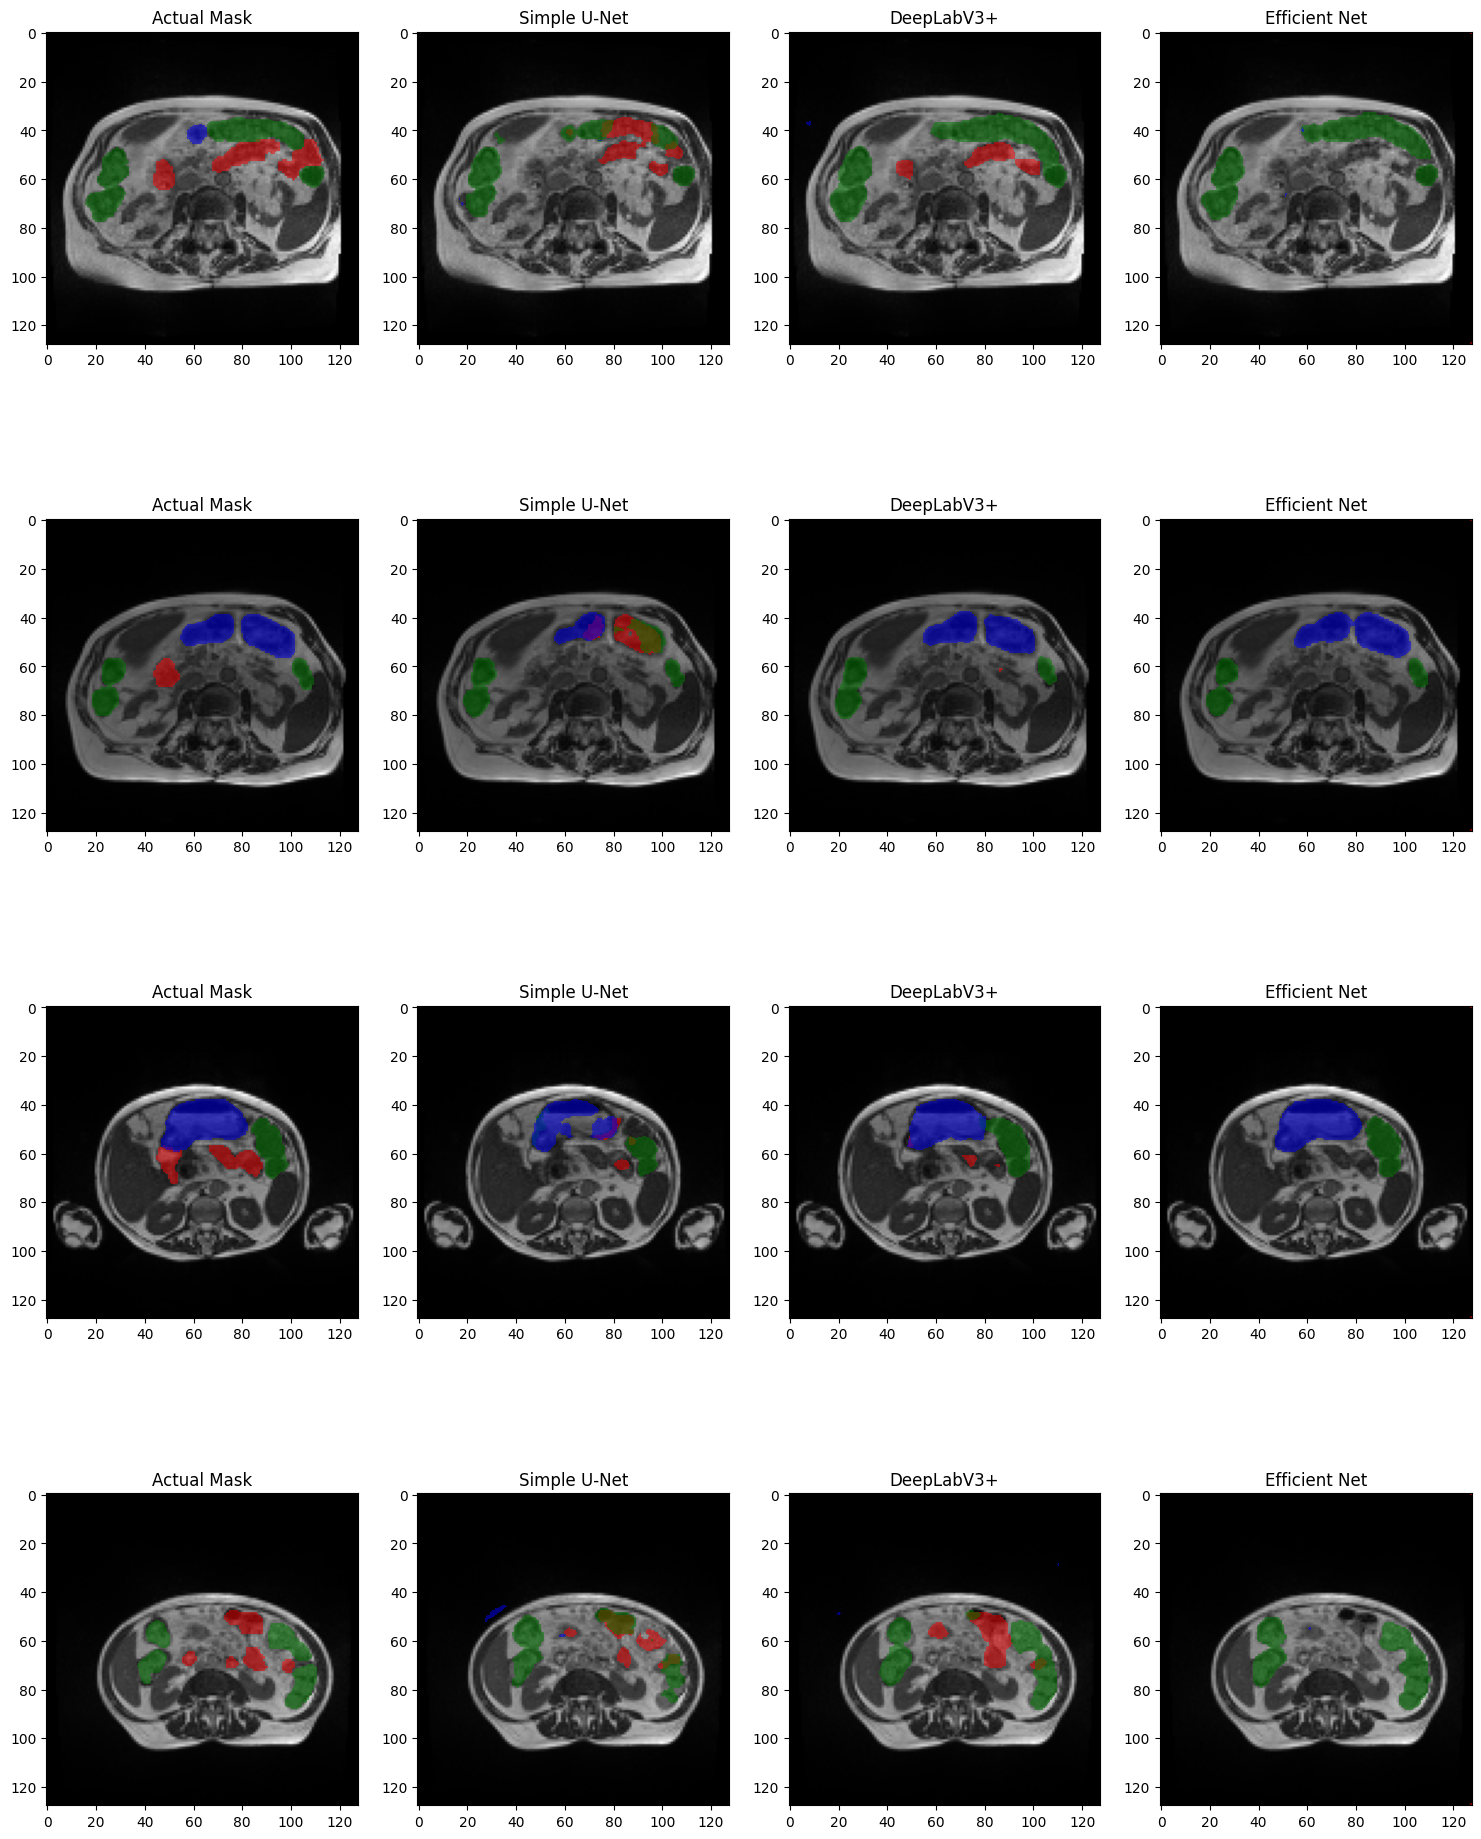

In [57]:
display_comparison(img_s, mask_s, pred_sunet, pred_dlv3, pred_en)

### Train, Test graphs

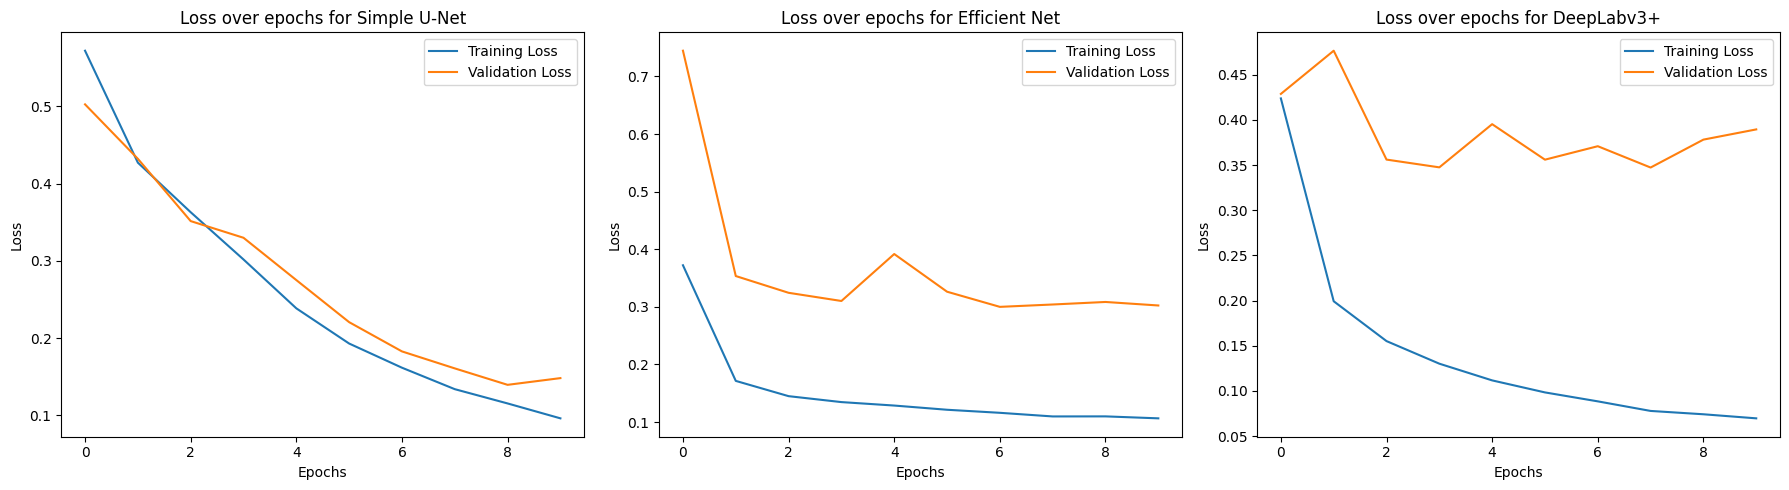

In [64]:
import matplotlib.pyplot as plt

# Data for three models
models = ['Simple U-Net', 'Efficient Net', 'DeepLabv3+']
train_losses = {
    'Simple U-Net': [
    0.5722, 0.4272, 0.3630, 0.3018, 0.2385,
    0.1929, 0.1616, 0.1338, 0.1153, 0.0960
],
    'Efficient Net': [0.3722, 0.1715, 0.145, 0.1347, 0.1287, 0.1214, 0.1161, 0.1098, 0.1099, 0.1065],
    'DeepLabv3+': [0.4237, 0.1992, 0.1551, 0.1301, 0.1116, 0.0983, 0.0884, 0.0778, 0.0741, 0.0696]
}
val_losses = {
    'Simple U-Net': [
    0.5027, 0.4322, 0.3515, 0.3299, 0.2751,
    0.2206, 0.1827, 0.1607, 0.1394, 0.1481
],
    'Efficient Net': [0.7446, 0.3535, 0.3244, 0.3102, 0.3917, 0.3263, 0.3, 0.3041, 0.3085, 0.3024],
    'DeepLabv3+': [0.4287, 0.4765, 0.356, 0.3474, 0.3952, 0.3559, 0.3708, 0.3472, 0.3781, 0.3894]
}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for each model
for i, model in enumerate(models):
    axs[i].plot(train_losses[model], label='Training Loss')
    axs[i].plot(val_losses[model], label='Validation Loss')
    axs[i].set_title(f'Loss over epochs for {model}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()


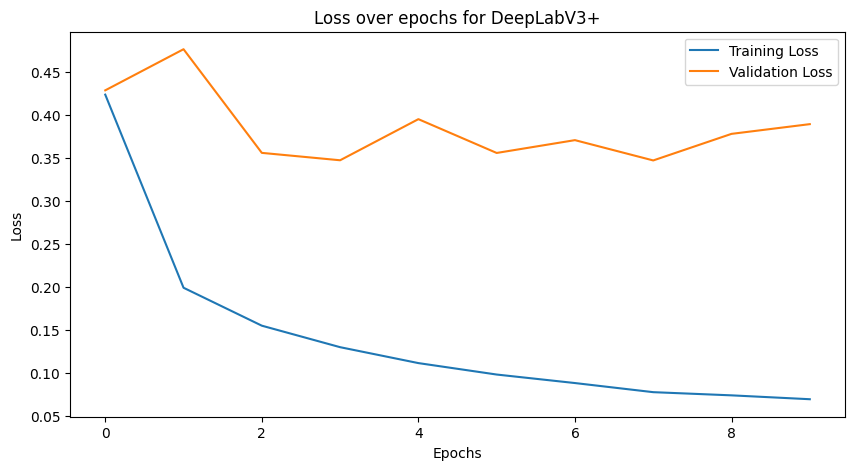

In [62]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(10))
train_losses = [0.4237, 0.1992, 0.1551, 0.1301, 0.1116, 0.0983, 0.0884, 0.0778, 0.0741, 0.0696]
val_losses = [0.4287, 0.4765, 0.356, 0.3474, 0.3952, 0.3559, 0.3708, 0.3472, 0.3781, 0.3894]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs for DeepLabV3+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

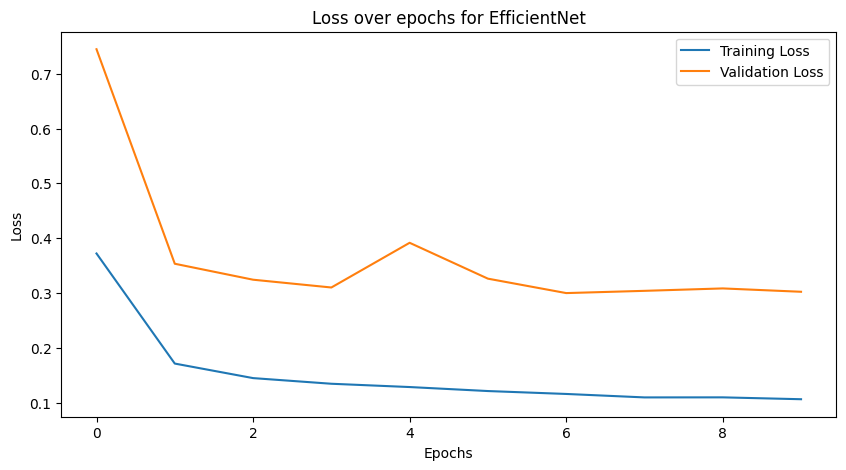

In [63]:
epochs = list(range(10))
train_losses = [0.3722, 0.1715, 0.145, 0.1347, 0.1287, 0.1214, 0.1161, 0.1098, 0.1099, 0.1065]
val_losses = [0.7446, 0.3535, 0.3244, 0.3102, 0.3917, 0.3263, 0.3, 0.3041, 0.3085, 0.3024]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs for EfficientNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

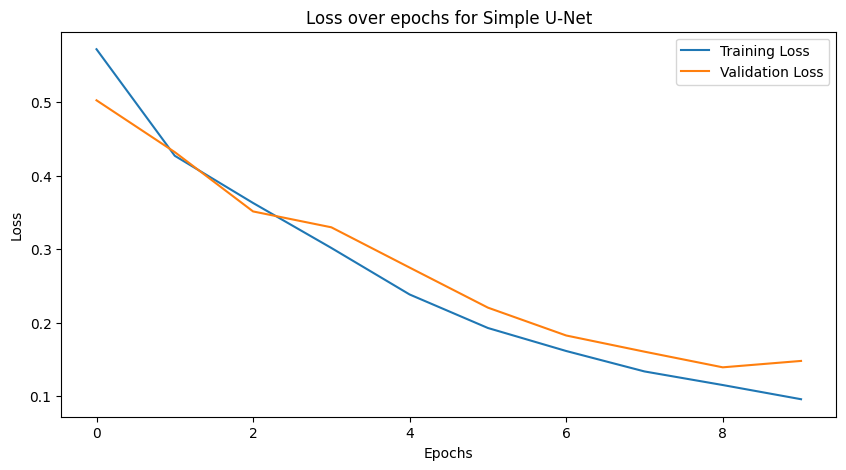

In [61]:
# Data
train_losses = [
    0.5722, 0.4272, 0.3630, 0.3018, 0.2385,
    0.1929, 0.1616, 0.1338, 0.1153, 0.0960
]
val_losses = [
    0.5027, 0.4322, 0.3515, 0.3299, 0.2751,
    0.2206, 0.1827, 0.1607, 0.1394, 0.1481
]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs for Simple U-Net')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(10))
train_losses = [0.4237, 0.1992, 0.1551, 0.1301, 0.1116, 0.0983, 0.0884, 0.0778, 0.0741, 0.0696]
val_losses = [0.4287, 0.4765, 0.356, 0.3474, 0.3952, 0.3559, 0.3708, 0.3472, 0.3781, 0.3894]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs for DeepLabV3+')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()